In [1]:
import sys
import os
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import sklearn
import scipy
import matplotlib.pyplot as plt
import itertools
import qinfer as qi
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from lfig import LatexFigure

sys.path.append("/home/bf16951/QMD")
import qmla

%matplotlib inline

In [2]:
run_path = "Dec_10/14_40"
# run_path = "Dec_11/20_26"

results = qmla.load_results(
    results_folder = "/home/bf16951/bc_results/",
    results_time = run_path,
    instance_id=1, 
)
q = results['qmla_instance']
es = results['exploration_strategy']

ratings = es.ratings_class.ratings_df

def get_model_f(mid):
    return q.model_f_scores[mid]

ratings['f_score_a'] = ratings['model_a'].apply(get_model_f)
ratings['f_score_b'] = ratings['model_b'].apply(get_model_f)

In [9]:
# Note this is now built into QMLA - update any changes in rating_system.py

def plot_rating_progress_single_model_static(
    ratings_df, 
    target_model_id, 
    return_df=False, 
    return_lf=None, 
    save_to_file=None
):

    # First isolate the ratings for this model
    model_identifiers = ["a", "b"]
    ratings_of_single_model = pd.DataFrame(
        columns=[
            'target', 'opponent', 
            'initial_rating_target', 'initial_rating_opponent', 
            'f_score_target', 'f_score_opponent', 
            'delta_r_target', 'final_rating_target',
            'idx', 
            'bayes_factor', 'generation', 'weight'
        ]
    )
    for target in model_identifiers:
        opponent = list(set(model_identifiers) - set(target))[0]

        target_ratings = ratings_df[
            ratings_df['model_{}'.format(target)] == target_model_id
            ][[
                'model_{}'.format(target),
                'model_{}'.format(opponent),
                'r_{}_initial'.format(target),
                'r_{}_initial'.format(opponent),
                'f_score_{}'.format(target), 
                'f_score_{}'.format(opponent),
                'delta_r_{}'.format(target),
                'r_{}_new'.format(target),
                'idx',
                'bayes_factor',
                'generation', 
                'weight',
                'winner'
            ]
        ]

        target_ratings.rename(
            columns={
                'model_{}'.format(target) : 'target', 
                'model_{}'.format(opponent) : 'opponent', 
                'r_{}_initial'.format(target) : 'initial_rating_target',
                'r_{}_initial'.format(opponent) : 'initial_rating_opponent', 
                'f_score_{}'.format(target) : 'f_score_target', 
                'f_score_{}'.format(opponent) : 'f_score_opponent',
                'r_{}_new'.format(target) : 'final_rating_target',
                'delta_r_{}'.format(target) : 'delta_r_target'
            }, 
            inplace=True
        )

        ratings_of_single_model = ratings_of_single_model.append(target_ratings, ignore_index=True)

    ratings_of_single_model['won_comparison'] = (ratings_of_single_model.winner == ratings_of_single_model.target)
    ratings_of_single_model.won_comparison.replace({True: "Won", False : "Lost"}, inplace=True)
    ratings_of_single_model.sort_values('idx', inplace=True)
    ratings_of_single_model['new_idx'] = list(range(len(ratings_of_single_model)))

    # Plot 3 perspectives on this data:
    # 1. How rating changes
    # 2. relative change per comparison
    # 3. strength of evidence each comparison

    plots_to_include = [
        "ratings_progress", 
        "delta_r", 
        "bf"
    ]
    include_f_ax = True

    lf = LatexFigure(
        fraction=0.9, 
        use_gridspec=True, 
        gridspec_layout=(len(plots_to_include),1),
        gridspec_params = {
            'height_ratios' : [0.35, 0.95, 0.35]
        }
    )

    if "bf" in plots_to_include:

        # Bayes factor comparisons
        ax2 = lf.new_axis()
        sns.barplot(
            data = ratings_of_single_model, 
            y = 'weight', 
            x = 'new_idx',
            hue='won_comparison',
            palette = {"Won" : "green", "Lost" : "purple"},
            dodge=False, 
            ax = ax2
        )
        ax2.legend(title=None, loc="upper left")
        ax2.set_ylabel(r"$\left| \log_{10}(B_{ij}) \right|$")

        generations = ratings_of_single_model.generation.unique()
        generation_change_indices = {
            g : ratings_of_single_model[
                ratings_of_single_model.generation == g].new_idx.max() + 0.5
            for g in generations
        }


    # Actual ratings
    if "ratings_progress" in plots_to_include:
        ax0 = lf.new_axis(
            ax_params = {'sharex' : ax2}
        )
        sns.scatterplot(
            data = ratings_of_single_model, 
            x = 'new_idx', 
            y = 'initial_rating_target',
            label=r"$\hat{H}_i$ \ before",
            color='green',
            marker='x', 
            s = 50,
            ax = ax0,
        )

        sns.lineplot(
            data = ratings_of_single_model, 
            x = 'new_idx', 
            y = 'final_rating_target', 
            label=r"$\hat{H}_i$ \ after",
            color = 'green', 
            ax = ax0
        )

        sns.scatterplot(
            x = 'new_idx', 
            y = 'initial_rating_opponent',
            data = ratings_of_single_model, 
            label=r"$\hat{H}_j$", 
            color = 'purple',
            marker = '+',
            s = 50, 
            ax = ax0, 
        )
        ax0.legend()
        ax0.set_ylabel('Rating')
        ax0.set_xticks([])
        ax0.set_xlabel("")
        ax0.legend(title="Ratings", loc="upper left", ncol=3)

    if include_f_ax:
        f_score_ax = ax0.twinx()
        sns.scatterplot(
            x = 'new_idx', 
            y = 'f_score_opponent',
            data = ratings_of_single_model, 
            label = r"$\hat{H}_j$",
            marker = 'd',
            s = 50, 
            color = 'purple',
            ax = f_score_ax, 
        )
        target_f_score = ratings_of_single_model.f_score_target.values[0]
        f_score_ax.axhline(
            target_f_score, 
            color = 'green', 
            ls = '--', 
            label = r"$\hat{H}_i$",
        )
        f_score_ax.set_ylabel(r"$F_1$-score")

        f_score_ax.legend(
            title=r"$F_1$-score",
            loc="lower left",
            ncol=2
        )
        f_score_ax.set_ylim(-0.1,1.1)
        f_score_ax.set_yticks([0, 0.5, 1])    


    if "delta_r" in plots_to_include:
        ax1 = lf.new_axis(
            ax_params = {'sharex' : ax2}
        )
        sns.barplot(
            data = ratings_of_single_model, 
            y = 'delta_r_target', 
            x = 'new_idx',
            hue='won_comparison',
            palette = {"Won" : "green", "Lost" : "purple"},
            dodge=False, 
            ax = ax1
        )
        ax1.set_ylabel(r"$\Delta R_i$")
        ax1.set_xticks([])
        ax1.set_xlabel("")
        ax1.get_legend().remove()




    for ax in lf.gridspec_axes.values():
        ax.set_xlabel("")
        ax.set_xticks([])

    bottom_ax = lf.gridspec_axes[(lf.num_rows-1, 0)]
    if len(generations) > 1:
        # vertical lines separating generations
        for ax in lf.gridspec_axes.values():
            for g in generation_change_indices.values():
                ax.axvline(g,ls='--', c='grey', alpha=0.6, )

        # label x-axis with generations
        xtick_locations = [generation_change_indices[g] for g in generations]
        xtick_locations.insert(0,0)
        centred_xticks = [ 
            np.mean([xtick_locations[i], xtick_locations[i+1] ]) 
            for i in range(len(xtick_locations)-1) 
        ]


        bottom_ax.set_xticklabels(generations)
        bottom_ax.set_xticks(centred_xticks)
        bottom_ax.set_xlabel("Generation")
    else:
        bottom_ax.set_xticks(
            range(len(ratings_of_single_model['new_idx'])),
        )
        bottom_ax.set_xticklabels(
            range(1, 1+len(ratings_of_single_model['new_idx']))
        )
        bottom_ax.set_xlabel("Comparison")

        
    if save_to_file is not None:
        lf.save(save_to_file)    

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


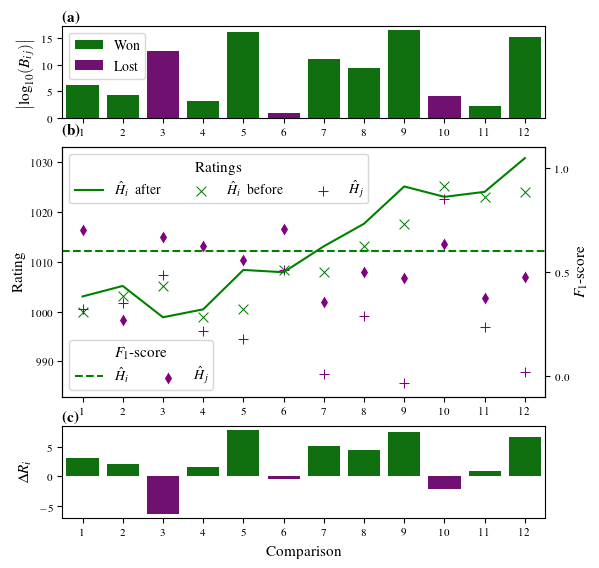

In [8]:
save_path = os.path.join(
    "/home/bf16951/thesis/theoretical_study/figures", 
    "single_generation_ratings_progression.pdf"
)


plot_rating_progress_single_model_static(
    ratings_df = ratings,
    target_model_id = 7 # for Dec_10/14_40,
    save_to_file = save_path
)